## Notebook to play with convolution for networks

- Setup a binary classification task
- Have peak probabilities for each class
- Then have some shifts also for the class and see if convolution can improve this

In [8]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math

Import the real dataset

In [19]:
filtered_dataset_dir = "G:\\Dev\\Data\\MSMS-NIST\\Python Filtered"
filtered_file_list = os.listdir(filtered_dataset_dir)
filtered_name_list = [filename[:-4] for filename in filtered_file_list]
number_files = len(filtered_file_list)
print(number_files)

intensities = pd.DataFrame(0.0, index = filtered_name_list, columns=range(1000), dtype=float)

for file in filtered_file_list:
    filepath = os.path.join(filtered_dataset_dir, file)
    filename = file[:-4]
    with open(filepath, 'r') as f:
        for index, line in enumerate(f):
            mass, intensity = line.split(" ")
            if not math.isnan(float(intensity)):
                intensities.at[filename, int(mass)-1] = float(intensity)
                
print(intensities.values)

40525
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Make a simple keras model to classify this data

In [20]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
def baseline_model():
    class_model = Sequential()
    class_model.add(Dense(50, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(10,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Following model is a convolutional model for this data

These methods generate spectra that include these shifts and convert the data into the necessary tensor format

- To generate a spectrum, we choose a number of peaks from a Poisson
- We then sample a shift from the class-specific shift distribution
- Sample a starting point
- Sample an intensity for the start and end
- Increment the spectra

In [21]:
def generate_shift_spec(n_bins = 100,n_peak_poiss = 2,intensity_poiss = 20,poss_shifts = [1,2,3,4,5,6,7,8,9,10],
                        shift_probs = [1.0/10 for i in range(10)]):
    spec = np.zeros(n_bins,np.double)
    n_peaks = np.random.poisson(n_peak_poiss)
    for i in range(n_peaks):
        shift = np.random.choice(poss_shifts,p = shift_probs)
        start_point = np.random.choice(n_bins-shift)
        i1 = np.random.poisson(intensity_poiss)
        i2 = np.random.poisson(intensity_poiss)
        spec[start_point] += i1
        spec[start_point+shift] += i2
    return spec


def shift_spec_into_tensor(spec_array,shift=[10,20]):
    n_spec,n_bins = spec_array.shape
    spec_tensor = np.zeros((n_spec,n_bins,len(shift)+1),np.double)
    for i in range(n_spec):
        spec = spec_array[i,:]
        shift_spec = np.copy(spec)
        for s in shift:
            shift_spec = np.vstack((shift_spec,np.hstack((spec[s:],np.zeros(s)))))
        spec_tensor[i,:,:] = shift_spec.T
    return spec_tensor[:,:,:,None]


def generate_shifts_from_spec(spec, intensity_poiss = 20):
    shift_bins = np.zeros(n_bins, np.double)
    for peak, intensity in enumerate(spec):
        for i in range(1,len(spec)-peak):
            average_intensity = (intensity + spec[peak+i]) / 2.0
            if average_intensity > 0 and intensity > 0 and spec[peak+i] > 0:
                shift_bins[i] += np.random.poisson(intensity_poiss)
                
    return shift_bins

In [22]:
def add_noise(X,n_noise = 5000):
    N,M = X.shape
    for n in range(N):
        X[n,:] += np.random.multinomial(np.random.poisson(n_noise),[1.0/M for m in range(M)])
    return X
def normalise(X):
    for i,row in enumerate(X):
        tot = row.sum()
        for j in range(len(row)):
            X[i,j] = (1.0*row[j])/tot
    return X

- Generate data for the two classes, add some noise and normalise
- Note that `use_shifts` is what the model uses.
- We don't need all the possible shifts to be in `use_shifts` as long as the kernel has sufficient width

In [23]:
X = intensities.values

# Compute the average total signal per spec and then add noise up to a proportion of that
mean_sig = ((X.sum(axis=1)).mean())
n_noise = int(mean_sig/4)
X = add_noise(X,n_noise=n_noise)
X = normalise(X)

#use_shifts = np.arange(1,21,5)
use_shifts = np.asarray([57])
print(use_shifts)

X_tensor = shift_spec_into_tensor(X,shift=use_shifts)
print(X_tensor.shape)

C:\Users\CherWei\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


[57]
(40525, 1000, 2, 1)


In [26]:
from keras.layers import Conv2D,Flatten,MaxPooling2D,AveragePooling2D
def conv_model(n_kernels = 2,kernel_width=1):
    class_model = Sequential()
    input_shape = (n_bins,len(use_shifts)+1,1)
    n_kernels = n_kernels
    
    pool_width = n_bins - (kernel_width+1)
    pool_size = (pool_width,1)
    
    kernel_size = (kernel_width,len(use_shifts)+1)
    class_model.add(Conv2D(n_kernels, input_shape=input_shape, 
                           kernel_initializer='normal', activation='relu',strides=1,
                          kernel_size = kernel_size))

#     class_model.add(AveragePooling2D(pool_size = pool_size))
    class_model.add(MaxPooling2D(pool_size = pool_size))
    class_model.add(Flatten())
    class_model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model


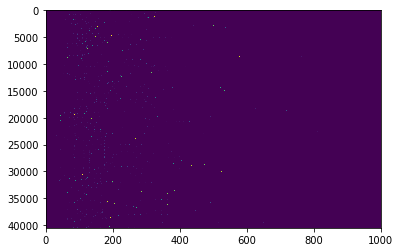

In [27]:
plt.imshow(X,aspect='auto')

Train the standard model - this is unlikely to work well!

- Note how many parameters is has - it overfits like mad

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 5,571
Trainable params: 5,571
Non-trainable params: 0
_________________________________________________________________


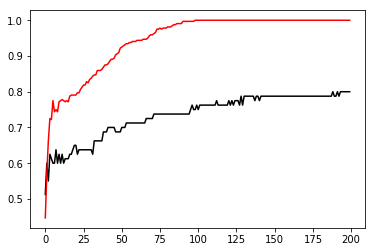

In [25]:
N,_,_,_ = X_tensor.shape
shuffle_order = np.random.permutation(N)
labels = [0 for i in range(n_in_class)] + [1 for i in range(n_in_class)]
labels = np.array(labels)[:,None]
epochs = 200
mod = baseline_model()
mod.summary()
history = mod.fit(X[shuffle_order,:],labels[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)

plt.plot(np.arange(epochs),history.history['val_acc'],'k')
plt.plot(np.arange(epochs),history.history['acc'],'r')

Train the convolutional model

- This will work and with only a small number of parameters!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 1, 3)          33        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 3)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 4         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


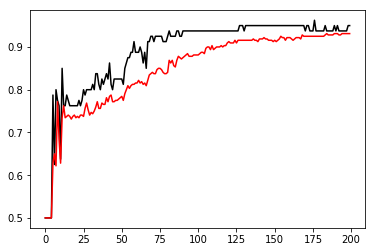

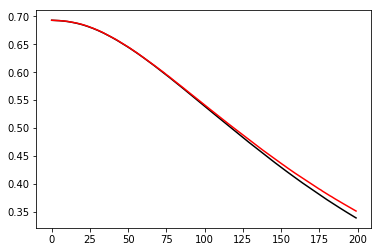

In [26]:
n_kernels = 3
kernel_width = 5
mod = conv_model(n_kernels = n_kernels,kernel_width=kernel_width)
mod.summary()
epochs = 200
history = mod.fit(X_tensor[shuffle_order,:,:],labels[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)
plt.plot(np.arange(epochs),history.history['val_acc'],'k')
plt.plot(np.arange(epochs),history.history['acc'],'r')
plt.figure()
plt.plot(np.arange(epochs),history.history['val_loss'],'k')
plt.plot(np.arange(epochs),history.history['loss'],'r')



Do some extra epochs if necessary

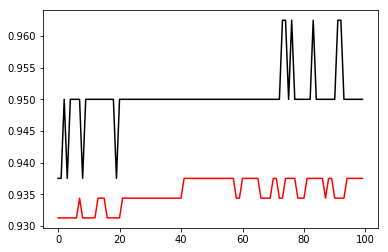

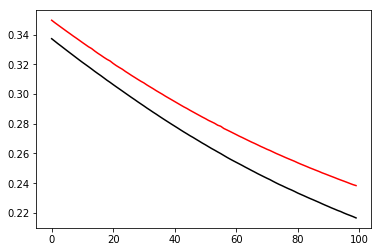

In [27]:
extra_epochs = 100
history = mod.fit(X_tensor[shuffle_order,:,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)
plt.plot(np.arange(extra_epochs),history.history['val_acc'],'k')
plt.plot(np.arange(extra_epochs),history.history['acc'],'r')
plt.figure()
plt.plot(np.arange(extra_epochs),history.history['val_loss'],'k')
plt.plot(np.arange(extra_epochs),history.history['loss'],'r')



Visualise the convolution weights

(5, 2, 1, 3)


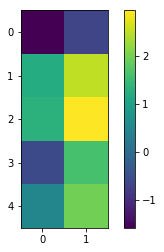

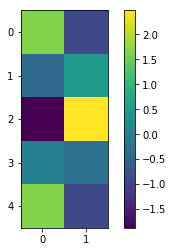

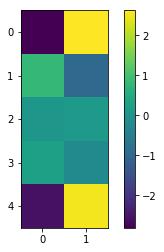

In [28]:
conv_layer = mod.layers[0]
weights = conv_layer.get_weights()
print(weights[0].shape)
w = weights[0][:,:,0,:]
for n in range(n_kernels):
    plt.figure()
    plt.imshow(w[:,:,n])
    plt.colorbar()

Visualise the weights into the last layer

<BarContainer object of 3 artists>

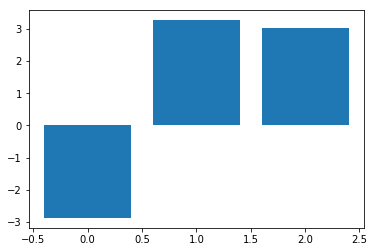

In [29]:
out_layer = mod.layers[-1]
w = out_layer.get_weights()[0]
plt.bar(range(n_kernels),w.flatten())

In [38]:
dummy_spec = np.zeros((2,n_bins))
start_pos = np.random.choice(n_bins - max(glycine_shift))
end_pos = start_pos + poss_shifts[class1_shift_probs.argmax()]
dummy_spec[0,start_pos] = np.random.poisson(10)
dummy_spec[0,end_pos] = np.random.poisson(10)

start_pos = np.random.choice(n_bins - max(poss_shifts))
dummy_spec[1,start_pos] = np.random.poisson(10)
end_pos = start_pos + poss_shifts[class2_shift_probs.argmax()]
dummy_spec[1,end_pos] = np.random.poisson(10)

dummy_spec = add_noise(dummy_spec,n_noise=50)
dummy_spec = normalise(dummy_spec)
dummy_tensor = shift_spec_into_tensor(dummy_spec,shift=use_shifts)
mod.predict(dummy_tensor)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  7. 12.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
(2, 100)


array([[0.30321068],
       [0.6257887 ]], dtype=float32)

<BarContainer object of 100 artists>

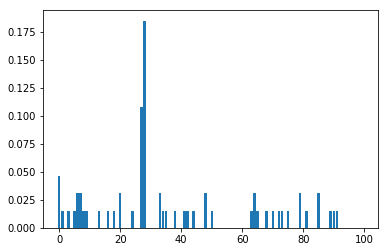

In [39]:
plt.bar(range(n_bins),dummy_spec[0,:])

Second model for comparison

In [40]:
def generate_shifts_from_spec(spec, intensity_poiss = 20):
    shift_bins = np.zeros(n_bins, np.double)
    for peak, intensity in enumerate(spec):
        for i in range(1,len(spec)-peak):
            average_intensity = (intensity + spec[peak+i]) / 2.0
            if average_intensity > 0 and intensity > 0 and spec[peak+i] > 0:
                shift_bins[i] += np.random.poisson(intensity_poiss)
                
    return shift_bins

In [41]:
data = []

for n in range(0, n_in_class):
    spec = generate_shift_spec(poss_shifts = glycine_shift,shift_probs=class1_shift_probs)
    shifts = generate_shifts_from_spec(spec)
    data.append(shifts)
    
for n in range(n_in_class, n_in_class*2):
    spec = generate_shift_spec(poss_shifts = poss_shifts, shift_probs=class2_shift_probs)
    shifts = generate_shifts_from_spec(spec)
    data.append(shifts)

X_shifts = np.array(data)
print(X_shifts.shape)

# Compute the average total signal per spec and then add noise up to a proportion of that
mean_sig = ((X_shifts.sum(axis=1)).mean())
n_noise = int(mean_sig/4)
X_shifts = add_noise(X_shifts,n_noise=n_noise)
X_shifts = normalise(X_shifts)

(400, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(400, 100)


(400, 100)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 5,571
Trainable params: 5,571
Non-trainable params: 0
_________________________________________________________________


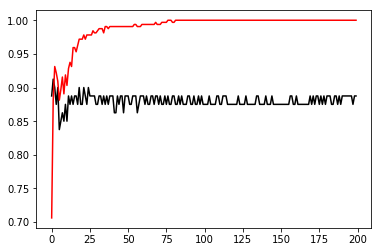

In [42]:
N,_ = X_shifts.shape
shuffle_order = np.random.permutation(N)
labels = [0 for i in range(n_in_class)] + [1 for i in range(n_in_class)]
labels = np.array(labels)[:,None]
print(X_shifts.shape)
epochs = 200
mod = baseline_model()
mod.summary()
history = mod.fit(X_shifts[shuffle_order,:],labels[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)

plt.plot(np.arange(epochs),history.history['val_acc'],'k')
plt.plot(np.arange(epochs),history.history['acc'],'r')

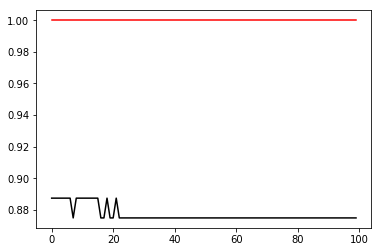

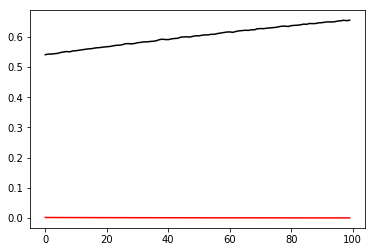

In [43]:
extra_epochs = 100
history = mod.fit(X_shifts[shuffle_order,:],labels[shuffle_order],epochs=extra_epochs,validation_split=0.2,verbose=0)
plt.plot(np.arange(extra_epochs),history.history['val_acc'],'k')
plt.plot(np.arange(extra_epochs),history.history['acc'],'r')
plt.figure()
plt.plot(np.arange(extra_epochs),history.history['val_loss'],'k')
plt.plot(np.arange(extra_epochs),history.history['loss'],'r')

In [44]:
X = []

#with glycine shifts
dummy_spec = np.zeros(n_bins)
start_pos = np.random.choice(n_bins - max(glycine_shift))
dummy_spec[start_pos] = np.random.poisson(10)
end_pos = start_pos + poss_shifts[class1_shift_probs.argmax()]
dummy_spec[end_pos] = np.random.poisson(10)

X.append(generate_shifts_from_spec(dummy_spec))

# with other shifts
dummy_spec = np.zeros(n_bins)
start_pos = np.random.choice(n_bins - max(poss_shifts))
dummy_spec[start_pos] = np.random.poisson(10)
end_pos = start_pos + poss_shifts[class2_shift_probs.argmax()]
dummy_spec[end_pos] = np.random.poisson(10)

X.append(generate_shifts_from_spec(dummy_spec))
dummy_shifts = np.array(X)

print(dummy_shifts.shape)

dummy_shifts = add_noise(dummy_shifts,n_noise=50)
dummy_shifts = normalise(dummy_shifts)
mod.predict(dummy_shifts)

(2, 100)
[[ 0. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 29.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
(2, 100)


array([[7.002519e-05],
       [1.000000e+00]], dtype=float32)

<BarContainer object of 100 artists>

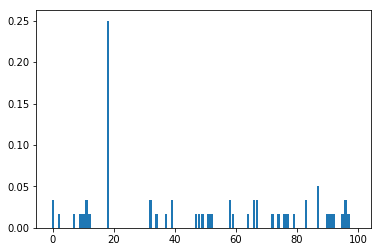

In [51]:
plt.bar(range(n_bins),dummy_shifts[1,:])